In [1]:
import os
import sys
import sv as SV
import numpy as np
import pylab as pl
import astropy.table as atable

from   tqdm.notebook import tqdm, trange
from   cmap import cmap

In [2]:
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask
from desispec.tsnr import tsnr2_to_efftime

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [17]:
# load compiled zsuccess rates to file
#dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
dat_dir = '/global/cscratch1/sd/mjwilson/desi/BGS/bgs-cmxsv/'

sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.v3.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.v3.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.v3.fits'))

(0.0, 20.0)

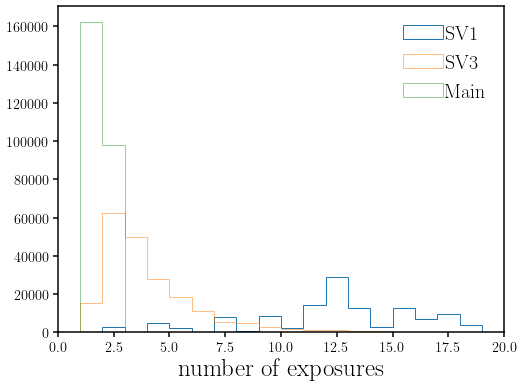

In [18]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

_ = sub.hist(sv1_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, label='SV1', histtype='step')
_ = sub.hist(sv3_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, alpha=0.5, label='SV3', histtype='step')
_ = sub.hist(main_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, alpha=0.5, label='Main', histtype='step')

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)

sub.set_xlabel('number of exposures', fontsize=25)

sub.set_xlim(0., 20)

In [19]:
sv1_deep = (sv1_gals['DEEP_EXPTIME'] > 2000) & (tsnr2_to_efftime(sv1_gals['TSNR2_BGS'].data, 'bgs') > 160.)
sv3_deep = (tsnr2_to_efftime(sv3_gals['TSNR2_BGS'].data, 'bgs') > 160.)

# Bad idea:
# (sv3_gals['DEEP_NUMEXP'] > 2) - accidentally prefers those with repeated redshifts. 

np.mean(sv1_deep), np.mean(sv3_deep)

INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-gpbdark.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-elg.fits apply scale factor = 1.261
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-gpbbright.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-lya.fits apply scale factor = 0.998
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-bgs.fits apply scale factor = 2.652
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/202008

(0.666603188205702, 0.8510129012402972)

In [20]:
ps, cs = np.unique(sv3_gals['PRIORITY'].data[sv3_deep], return_counts=True)

for p, c in zip(ps, cs):
    print('{:d}\t{:d}'.format(p, c))

2	66172
90	8
82000	163
82100	561
92000	604
92100	1038
101400	12
101500	63
102000	40475
102100	65108
102998	6


In [21]:
# Remove repeats: starting priority only. 
sv3_deep &= np.isin(sv3_gals['PRIORITY'].data, np.array([102100, 102000])) 

ps, cs = np.unique(sv3_gals['PRIORITY'].data[sv3_deep], return_counts=True)

for p, c in zip(ps, cs):
    print('{:d}\t{:d}'.format(p, c))

102000	40475
102100	65108


In [22]:
sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0

sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

In [36]:
def plot_zsuccess(sv1_gals, sv3_gals):
    fig = plt.figure(figsize=(8,6))
    sub = fig.add_subplot(111)

    rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv1_gals['RMAG_DRED'][sv1_deep & ~sv1_lowq], sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq], range=(12, 22), nbins=20)
    sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C2')
    print(zsrate)
    sub.plot(rmid, zsrate, c='C2', ls='--', label='SV1')

    rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv3_gals['RMAG_DRED'][sv3_deep], sv3_gals['ZSUCCESS'][sv3_deep], range=(12, 22), nbins=20)
    sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C0')
    sub.plot(rmid, zsrate, c='C0', lw=3, label='$1\%$')

    for hh in np.arange(1., 0.95, -0.01):
        sub.axhline(hh, color='k', linestyle='-', lw=0.1)

    sub.axvline(19.5, color='k', linestyle='--')
    sub.text(19.4, 0.63, 'BGS Bright', ha='right', fontsize=25, rotation=0)
    sub.text(19.6, 0.63, 'Faint', ha='left', fontsize=25, rotation=0)

    sub.legend(loc='lower left', fontsize=25, handletextpad=0.3)
    sub.set_xlabel('$r$ magnitude', fontsize=25)
    sub.set_xlim(15, 20.5)
    sub.set_ylabel('$z$ success rate', fontsize=25)
    sub.set_ylim(0.6, 1.08)

In [37]:
def plot_zsuccess_magfib(sv1_gals, sv3_gals):
    fig = plt.figure(figsize=(6,6))
    sub = fig.add_subplot(111)

    sub.scatter(sv1_gals['RMAG_DRED'][sv1_deep & ~sv1_lowq], sv1_gals['FIBER_RMAG_DRED'][sv1_deep & ~sv1_lowq], c='C0', s=1, label='SV1')
    sub.scatter(sv3_gals['RMAG_DRED'][sv3_deep],             sv3_gals['FIBER_RMAG_DRED'][sv3_deep], c='C1', s=1, label='SV3')

    sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=2)
    sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=2)
    sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
    sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

    sub.set_xlabel('$r$ magnitude', fontsize=25)
    sub.set_xlim(14, 22)
    sub.set_ylabel(r'$r_{\rm fiber}$ magnitude', fontsize=25)
    sub.set_ylim(16, 26)
    sub.legend(frameon=False, loc=2)

In [38]:
def plot_zsuccess_magfib_hex(sv1_gals, sv3_gals):
    fig = plt.figure(figsize=(14,6))
    sub = fig.add_subplot(121)

    hb = sub.hexbin(sv1_gals['RMAG_DRED'][sv1_deep & ~sv1_lowq], sv1_gals['FIBER_RMAG_DRED'][sv1_deep & ~sv1_lowq], C=sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq].astype(float), 
                    edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(14, 22, 16, 26), gridsize=30, vmin=0., vmax=1., mincnt=2, cmap=cmap)#'Spectral_r')

    #sub.scatter([], [], marker='h', s=300, label='SV1', c='C3', alpha=0.75)
    #sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C3', edgecolor='k')
    sub.text(0.05, 0.95, r'BGS All', ha='left', va='top', transform=sub.transAxes, fontsize=30)
    sub.text(0.95, 0.05, 'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

    #sub.text(14.5, 20.3, 'fiber-magnitude cut', rotation=39, fontsize=15)
    #sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
    #sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=3)
    #sub.plot([20., 22.], [22.9, 24.9], c='k', ls='--', lw=3)

    #sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
    #sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

    sub.set_xlim(14, 21)
    sub.set_xticks([14, 16, 18, 20])
    sub.set_ylim(16, 25)
    sub.set_yticks([16, 18, 20, 22, 24])

    sub = fig.add_subplot(122)

    hb = sub.hexbin(sv3_gals['RMAG_DRED'][sv3_deep], sv3_gals['FIBER_RMAG_DRED'][sv3_deep], C=sv3_gals['ZSUCCESS'][sv3_deep].astype(float),
                    edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(14, 22, 16, 26), gridsize=30, vmin=0., vmax=1., mincnt=2, cmap=cmap)

    sub.text(0.95, 0.05, '$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)
    sub.set_xlabel('$r$', fontsize=25)
    sub.set_xlim(14, 21)
    sub.set_xticks([14, 16, 18, 20])
    sub.set_ylim(16, 25)
    sub.set_yticks([16, 18, 20, 22, 24])
    sub.set_yticklabels([])

    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel(r'$r$ magnitude', labelpad=10, fontsize=25) 
    bkgd.set_ylabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    fig.subplots_adjust(wspace=0.1, right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
    fig.savefig('figs/zsuccess_rmag_rfib.pdf', bbox_inches='tight')

In [39]:
def plot_zsuccess_colcol_hex(sv1_gals, sv3_gals):
    fig = plt.figure(figsize=(14,6))
    sub = fig.add_subplot(121)

    hb = sub.hexbin((sv1_gals['GMAG_DRED'] - sv1_gals['RMAG_DRED'])[sv1_deep & sv1_brgt], (sv1_gals['RMAG_DRED'] - sv1_gals['ZMAG_DRED'])[sv1_deep & sv1_brgt], C=sv1_gals['ZSUCCESS'][sv1_deep & sv1_brgt].astype(float), 
                    reduce_C_function=np.mean, extent=(-1, 4, -2, 3), gridsize=30, vmin=0., vmax=1., mincnt=2, 
                    cmap=cmap, edgecolors='k', linewidth=1.)

    sub.text(0.05, 0.95, r'BGS Bright', ha='left', va='top', transform=sub.transAxes, fontsize=30)
    sub.text(0.05, 0.84, r'$r < 19.5$', ha='left', va='top', transform=sub.transAxes, fontsize=30)
    sub.text(0.95, 0.05, 'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

    sub.set_xlim(-1, 2.5)
    sub.set_ylim(-1.5, 2)
    sub.set_xticks([-1., 0., 1., 2.])
    sub.set_yticks([-1, 0., 1., 2.])

    sub = fig.add_subplot(122)

    hb = sub.hexbin((sv3_gals['GMAG_DRED'] - sv3_gals['RMAG_DRED'])[sv3_deep & sv3_brgt], (sv3_gals['RMAG_DRED'] - sv3_gals['ZMAG_DRED'])[sv3_deep & sv3_brgt], C=sv3_gals['ZSUCCESS'][sv3_deep & sv3_brgt].astype(float), 
                     reduce_C_function=np.mean, extent=(-1, 4, -2, 3), gridsize=30, vmin=0., vmax=1., mincnt=2, 
                     cmap=cmap, edgecolors='k', linewidth=1.)

    sub.text(0.95, 0.05, '$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

    sub.set_xlim(-1, 2.5)
    sub.set_ylim(-1.5, 2)
    sub.set_yticklabels([])
    sub.set_xticks([-1., 0., 1., 2.])
    sub.set_yticks([-1, 0., 1., 2.])

    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel(r'$g - r$ color', labelpad=10, fontsize=25) 
    bkgd.set_ylabel(r'$r - z$ color', labelpad=10, fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    fig.subplots_adjust(wspace=0.1, right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
    fig.savefig('figs/zsuccess_gr_rz.pdf', bbox_inches='tight')

In [40]:
def plot_zsuccess_faintfibcol_hex(sv1_gals, sv3_gals):
    fig = plt.figure(figsize=(15,6))
    sub = fig.add_subplot(121)

    hb = sub.hexbin(sv1_gals['FIBER_RMAG_DRED'][sv1_deep & sv1_fain], sv1_gals['FAINT_FIBCOL'][sv1_deep & sv1_fain], C=sv1_gals['ZSUCCESS'][sv1_deep & sv1_fain].astype(float),
                    reduce_C_function=np.mean, extent=(19.5, 23.3, -1.2, 1.8), gridsize=30, vmin=0., vmax=1., mincnt=5,
                    cmap=cmap, edgecolors='k', linewidth=1.)

    sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
    sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
    sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

    sub.text(0.05, 0.95, r'BGS Faint', ha='left', va='top', transform=sub.transAxes, fontsize=30)
    sub.text(0.95, 0.05, 'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

    sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
    sub.set_ylim(-1.2, 1.8)
    sub.set_xlim(19.5, 23.3)
    sub.set_xticks([20, 21, 22, 23])

    sub = fig.add_subplot(122)
    hb = sub.hexbin(sv3_gals['FIBER_RMAG_DRED'][sv3_deep & sv3_fain], sv3_gals['FAINT_FIBCOL'][sv3_deep & sv3_fain], C=sv3_gals['ZSUCCESS'][sv3_deep & sv3_fain].astype(float),
                    reduce_C_function=np.mean, extent=(19.5, 23.3, -1.2, 1.8), gridsize=30, vmin=0., vmax=1., mincnt=5,
                    cmap=cmap, edgecolors='k', linewidth=1.)

    sub.text(0.95, 0.05, '$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

    sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
    sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
    sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

    sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
    sub.set_ylim(-1.2, 1.8)
    sub.set_xlim(19.5, 23.3)
    sub.set_xticks([20, 21, 22, 23])
    sub.set_yticklabels([])

    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
    bkgd.set_ylabel(r'$(z - w1) - 1.2 (g - r) + 1.2$', labelpad=10, fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    fig.subplots_adjust(wspace=0.1, right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
    fig.savefig('figs/zsuccess_rfib_col.pdf', bbox_inches='tight')

[1.         1.         1.         0.975      0.99411765 0.98866213
 0.99087353 0.99331997 0.9922366  0.98623465 0.98054327 0.96721907
 0.92892282 0.82100471]


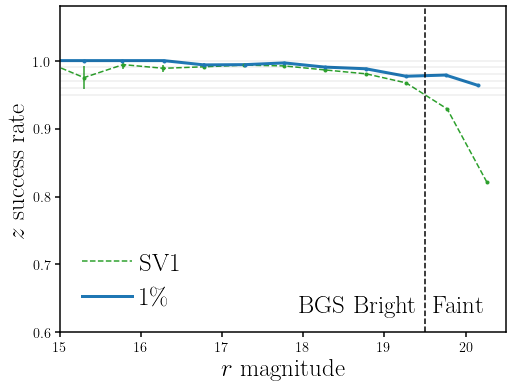

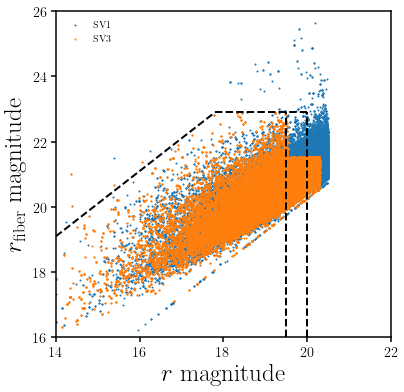

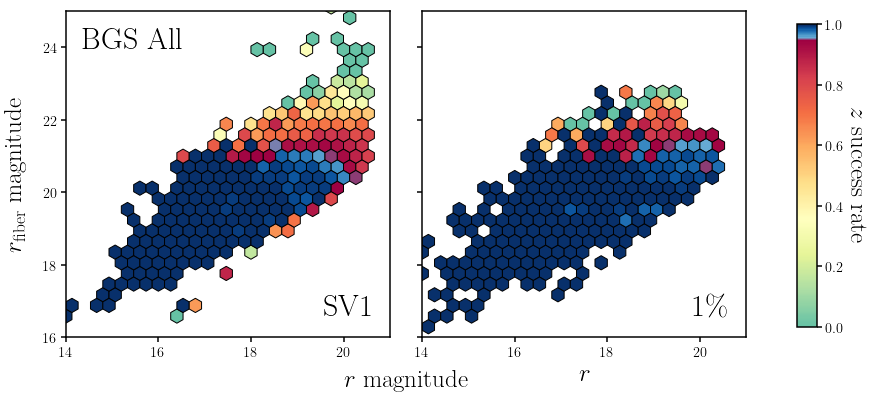

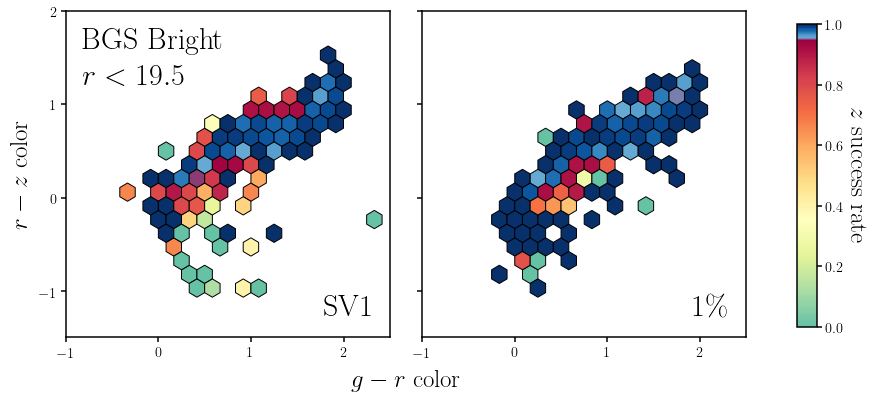

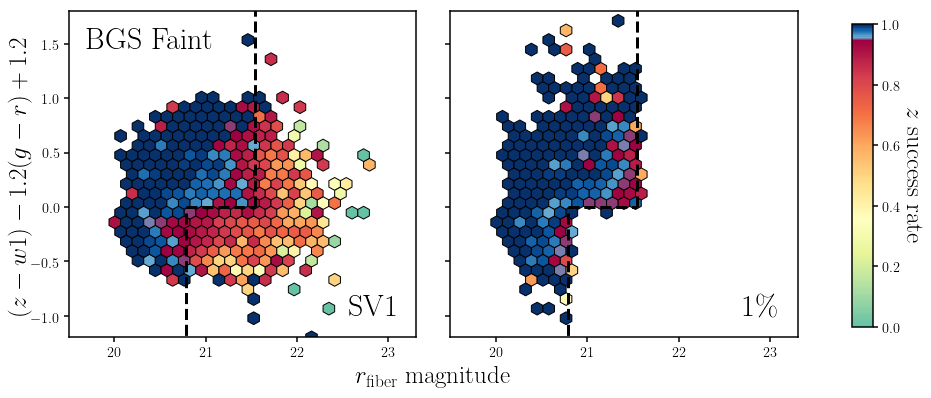

In [42]:
plot_zsuccess(sv1_gals, sv3_gals)
plot_zsuccess_magfib(sv1_gals, sv3_gals)
plot_zsuccess_magfib_hex(sv1_gals, sv3_gals)
plot_zsuccess_colcol_hex(sv1_gals, sv3_gals)
plot_zsuccess_faintfibcol_hex(sv1_gals, sv3_gals)

[1.         1.         1.         0.9875     0.99411765 0.98866213
 0.99087353 0.99398798 0.99334566 0.99025837 0.98622868 0.98008431
 0.96197602 0.9011868 ]


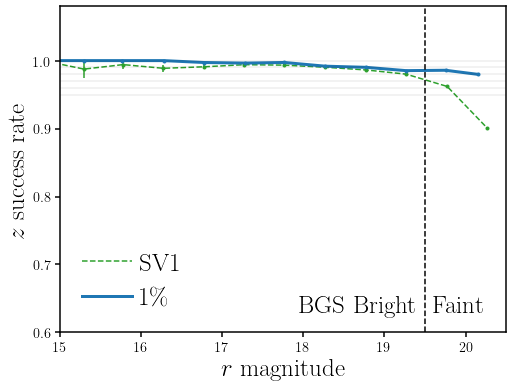

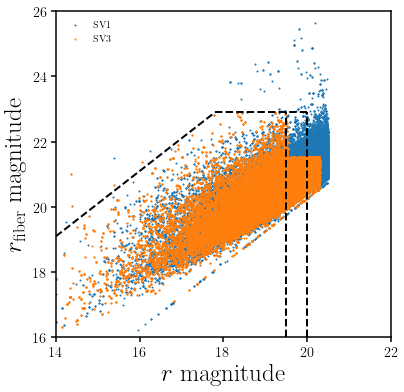

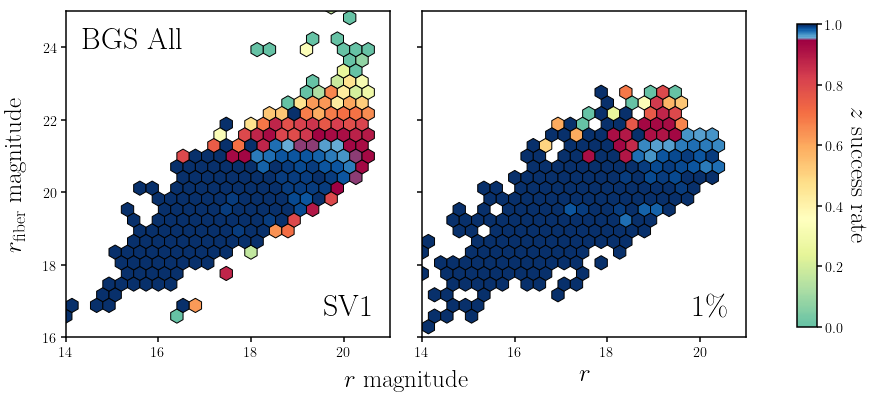

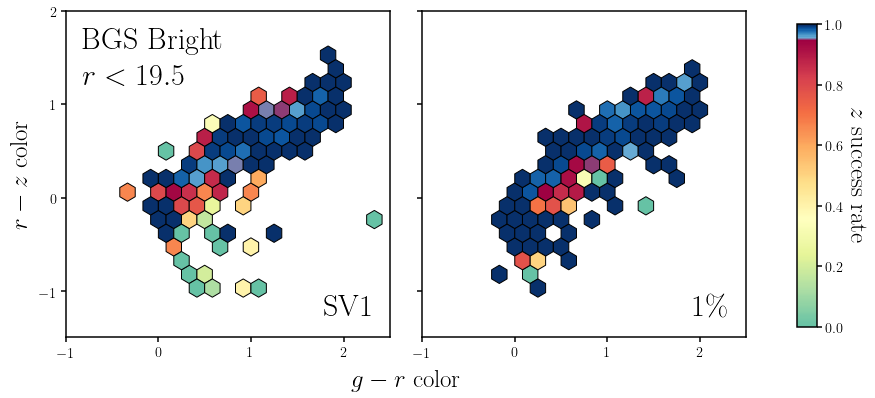

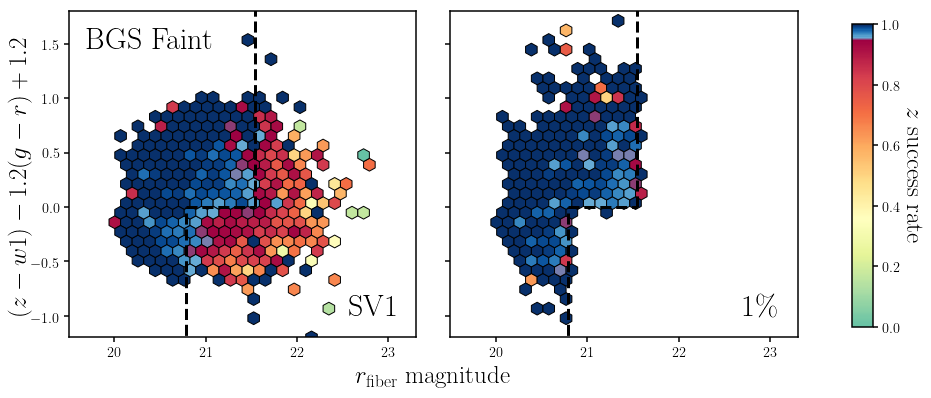

In [43]:
sv1_gals20 = SV.set_zbest_exp_zsuccess(sv1_gals, exp_dX2=20.)
sv3_gals20 = SV.set_zbest_exp_zsuccess(sv3_gals, exp_dX2=20.)

plot_zsuccess(sv1_gals20, sv3_gals20)
plot_zsuccess_magfib(sv1_gals20, sv3_gals20)
plot_zsuccess_magfib_hex(sv1_gals20, sv3_gals20)
plot_zsuccess_colcol_hex(sv1_gals20, sv3_gals20)
plot_zsuccess_faintfibcol_hex(sv1_gals20, sv3_gals20)

# Done.